<a href="https://colab.research.google.com/github/erwanBellon/Project-ML-SDM/blob/main/code/CNN_model_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Setup



In [ ]:

#Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Cloning repo or fetch latest changes and path management
%cd /content
!rm -rf Project-ML-SDM
!git clone https://github.com/erwanBellon/Project-ML-SDM.git
%cd /content/Project-ML-SDM
!git pull

import os
from pathlib import Path

# Move into the project directory
%cd /content/Project-ML-SDM/code
print("Current working directory:", Path.cwd())

# Define main project dir and outputs
PROJECT_ROOT_DIR = Path.cwd().parent
OUTPUTS_PATH = PROJECT_ROOT_DIR / "outputs"
OUTPUTS_PATH.mkdir(parents=True, exist_ok=True)
print("Outputs will be saved to:", OUTPUTS_PATH)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras import regularizers

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU detected. CNNs can be slow without GPU.")

# Common imports
import pandas as pd
import numpy as np
!pip install rasterio
import rasterio
from sklearn.model_selection import train_test_split
!pip install keras-tuner --upgrade
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
from google.colab import drive
!pip install pyreadr
import pyreadr


# To make notebook reproducible
np.random.seed(123)
tf.random.set_seed(123)

# For plots
import matplotlib.pyplot as plt
%matplotlib inline

# Load Tensorboard
%load_ext tensorboard

/content
Cloning into 'Project-ML-SDM'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 518 (delta 38), reused 19 (delta 19), pack-reused 450 (from 1)
Receiving objects: 100% (518/518), 17.59 MiB | 12.71 MiB/s, done.
Resolving deltas: 100% (389/389), done.
/content/Project-ML-SDM
Already up to date.
/content/Project-ML-SDM/code
Current working directory: /content/Project-ML-SDM/code
Outputs will be saved to: /content/Project-ML-SDM/outputs
No GPU detected. CNNs can be slow without GPU.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.2/776.2 kB 13.2 MB/s eta 0:00:00


In [ ]:
print(Path.cwd())

/content/Project-ML-SDM/code


# Part 2: Load files
## 2.1: Load the presences and absences landcover crops

In [ ]:
# --- Load images ---
presences_path = Path("../data/cropped_landcover/presences")
absences_path = Path("../data/cropped_landcover/absences")

def load_images_from_folder(folder):
    tif_files = sorted(folder.glob("*.tif"))
    images = []
    image_indices = []
    for tif in tif_files:
        with rasterio.open(tif) as src:
            img = src.read()
            img = np.transpose(img, (1,2,0))
            images.append(img.astype(np.float32))
        # Extract the line index from the filename (assuming `crop_3000_118.tif`)
        idx = int(tif.stem.split("_")[-1])
        image_indices.append(idx)
    return np.array(images), np.array(image_indices)

images_pres, indices_pres = load_images_from_folder(presences_path)
images_abs, indices_abs = load_images_from_folder(absences_path)
print(f"Presences: {images_pres.shape}, Absences: {images_abs.shape}")

# Build dataset & labels
X = np.concatenate([images_pres, images_abs], axis=0)
y = np.concatenate([np.ones(len(images_pres)), np.zeros(len(images_abs))], axis=0).astype(np.int32)
image_indices = np.concatenate([indices_pres, indices_abs], axis=0)  # all image row indices

# --- Load table data ---
rds_path = Path("../data/Table_preds/function_3_100.rds")

result = pyreadr.read_r(rds_path)
table_df = result[None]  # get DataFrame

# Select only the rows corresponding to actual images
table_features_all = table_df[['MAP','MAT']].astype(float)
table_features = table_features_all.iloc[image_indices].reset_index(drop=True)


# Normalize
#table_features = (table_features - table_features.min()) / (table_features.max() - table_features.min())
#table_features = table_features.to_numpy(dtype=np.float32)


X_train, X_temp, table_train, table_temp, y_train, y_temp = train_test_split(
    X, table_features, y,
    test_size=0.2,
    random_state=123,
    stratify=y
)

X_valid, X_test, table_valid, table_test, y_valid, y_test = train_test_split(
    X_temp, table_temp, y_temp,
    test_size=0.5,
    random_state=123,
    stratify=y_temp
)

# Normalize using TRAIN ONLY

min_vals = table_train.min(axis=0)
max_vals = table_train.max(axis=0)

table_train = (table_train - min_vals) / (max_vals - min_vals)
table_valid = (table_valid - min_vals) / (max_vals - min_vals)
table_test  = (table_test  - min_vals) / (max_vals - min_vals)

table_train = table_train.to_numpy(dtype=np.float32)
table_valid = table_valid.to_numpy(dtype=np.float32)
table_test  = table_test.to_numpy(dtype=np.float32)


Presences: (117, 30, 30, 1), Absences: (200, 30, 30, 1)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train, table_train), y_train))
valid_ds = tf.data.Dataset.from_tensor_slices(((X_valid, table_valid), y_valid))
test_ds  = tf.data.Dataset.from_tensor_slices(((X_test, table_test), y_test))


# Add `.name` attribute like TFDS
train_ds.name = "Training"
valid_ds.name = "Validation"
test_ds.name  = "Test"

Note that there is some data leakage here as I pre-process part of my test set with the data of the training for normalizing the features. I don't have the time to change that... I've realised to late

## 2.3: Data exploration

In [ ]:
# @title
def dataset_info_multi(dataset):
    """
    Explore multi-input dataset: images + table features.
    Displays some sample images with their labels and table features (MAP, MAT).
    """
    # Extract number of samples
    num_samples = dataset.cardinality().numpy()
    print(f"\n{dataset.name} set contains {num_samples} data samples.",
          "Let's visualize some of them...\n")

    # Shuffle dataset and take a few examples
    sample_batch = dataset.shuffle(100).take(5)

    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    # Custom colormap (index 0 → white, index 1 → dark green)
    binary_cmap = ListedColormap(["white", "darkgreen"])

    plt.figure(figsize=(12, 4))
    for idx, ((img, table_feat), label) in enumerate(sample_batch):
        plt.subplot(1, 5, idx + 1)
        img_np = img.numpy()
        if img_np.shape[-1] == 1:  # grayscale
            img_np = img_np.squeeze(-1)
        plt.imshow(img_np, cmap=binary_cmap, vmin=0, vmax=1)
        plt.title(f"L:{int(label.numpy())}\nMAP:{table_feat[0].numpy():.2f}\nMAT:{table_feat[1].numpy():.2f}")
        plt.axis("off")

    plt.show()



Training set contains 253 data samples. Let's visualize some of them...



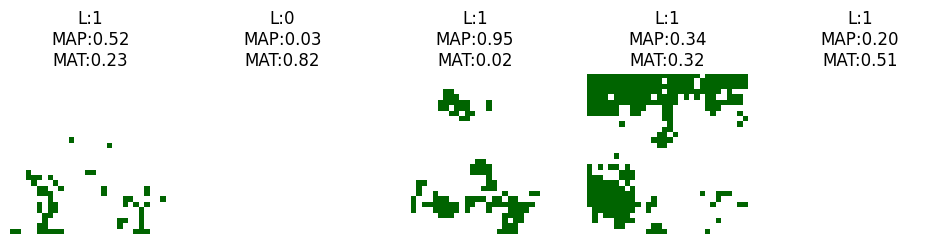


Test set contains 32 data samples. Let's visualize some of them...



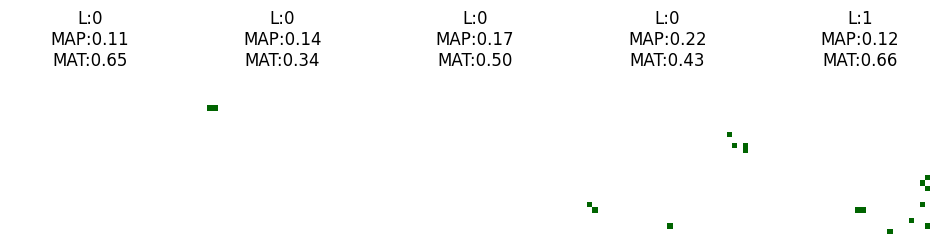


Validation set contains 32 data samples. Let's visualize some of them...



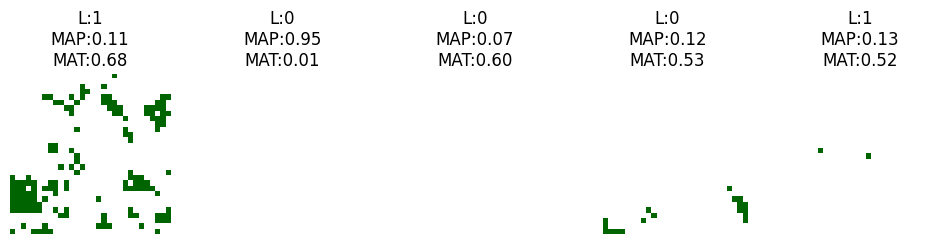

In [ ]:
dataset_info_multi(train_ds)
dataset_info_multi(test_ds)
dataset_info_multi(valid_ds)


In [ ]:
# @title
def dataset_pixel_info_multi(dataset, max_samples=None):
    """
    Explore multi-input dataset: images + table features.
    Prints pixel info and displays some samples with label and table values.
    """

    pixel_values = []
    nan_count = 0
    inf_count = 0
    total_images = 0

    for i, ((images, table_features), labels) in enumerate(dataset):
        imgs_np = images.numpy()
        table_np = table_features.numpy()
        labels_np = labels.numpy()

        # Flatten the batch of images into 1D array
        flat_pixels = imgs_np.ravel()

        # Count NaNs and Infs
        nan_count += np.isnan(flat_pixels).sum()
        inf_count += np.isinf(flat_pixels).sum()

        # Keep only finite values for unique checking
        finite_pixels = flat_pixels[np.isfinite(flat_pixels)]
        pixel_values.extend(finite_pixels)

        total_images += imgs_np.shape[0]
        if max_samples is not None and total_images >= max_samples:
            break

    pixel_values = np.array(pixel_values)
    unique_values = np.unique(pixel_values)

    print(f"Total images checked: {total_images}")
    print(f"NaN pixels: {nan_count}")
    print(f"Inf pixels: {inf_count}")
    print(f"Number of unique finite pixel values: {len(unique_values)}")
    print(f"Some unique pixel values: {unique_values[:20]}{'...' if len(unique_values) > 20 else ''}")

In [ ]:
dataset_pixel_info_multi(train_ds, max_samples=100)   # check first 100 images
dataset_pixel_info_multi(valid_ds)                     # check all validation images
dataset_pixel_info_multi(test_ds)                      # check all test images


Total images checked: 120
NaN pixels: 3307
Inf pixels: 0
Number of unique finite pixel values: 1
Some unique pixel values: [1.]
Total images checked: 960
NaN pixels: 26839
Inf pixels: 0
Number of unique finite pixel values: 1
Some unique pixel values: [1.]
Total images checked: 960
NaN pixels: 27152
Inf pixels: 0
Number of unique finite pixel values: 1
Some unique pixel values: [1.]


## 2.2:  Preprocessing function for the images and labels in our dataset. The function should set the image size to 30x30

As the aim of the model is to produce suitability map based on landcover (i.e. continuous output values between 0 and 1) I one-hot encore the labels.

In [ ]:
def preprocess_multi_inputs(inputs, label):
    image, table = inputs
    # Convert image to float32 and add channel dimension if needed
    image = tf.cast(image, tf.float32)
    # Replace Nan (non-forest) with 0s
    image = tf.where(tf.math.is_nan(image), 0.0, image)

    if len(image.shape) == 3:  # (H,W,C) or (H,W)
        image = tf.expand_dims(image, -1)  # ensures (H,W,1)
    # Table should already be (batch_size, 2) after batching
    table = tf.cast(table, tf.float32)
    label = tf.cast(label, tf.float32)
    return (image, table), label

In [ ]:
BATCH_SIZE = 8 #Instead of updating weights after each sample, the model updates weights after 8 samples at once. --> More stable gradients, Less noisy learning, Regularisation effect, Acts like implicit noise, Better GPU utilisation	Parallel computation
train_ds = (
    tf.data.Dataset.from_tensor_slices(((X_train, table_train), y_train))
      .shuffle(1000, reshuffle_each_iteration=True)   # Prevents the model from seeing correlated samples in sequence. Breaks spatial / temporal autocorrelation
      .map(preprocess_multi_inputs, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)
valid_ds = (
    tf.data.Dataset.from_tensor_slices(((X_valid, table_valid), y_valid))
      .map(preprocess_multi_inputs, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices(((X_test, table_test), y_test))
      .map(preprocess_multi_inputs, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

# Add `.name` attribute like TFDS
train_ds.name = "Training"
valid_ds.name = "Validation"
test_ds.name  = "Test"


# 3. CNN model Training

After some first manual trials, I decided to perform gridSearch for these values:

| Hyperparameter    | New proposed Grid              | Why                                   |
| ----------------- | ------------------------------ | ------------------------------------- |
| filters1          | **[16,32]**                       | 8 was too small; I reached good AUC |
| filters2          | **[32, 64]**                   | test small bump only
| filters3          | **[64, 128]**                   | test small bump only                        |
| dense_units       | **[32, 64, 128]**                   | both fit my curve                   |
| dropout           | **[0.2, 0.3, 0.4]**            | control soft overfitting              |
| **learning rate** | **[1e-3, 5e-4, 1e-4]** | based on my LR

In [ ]:
def build_model(hp):
    # CNN Filters to try
    filters1 = hp.Choice("filters1", values=[16, 32]) # 32
    filters2 = hp.Choice("filters2", values=[32, 64]) # 32
    filters3 = hp.Choice("filters3", values=[64, 128]) # 128

    # Filters kernel size
    kernel_size = hp.Choice("kernel_size", [3, 5]) # 5

    # Dense Units
    dense_units = hp.Choice("dense_units", values=[32, 64, 128]) # 32

    # Dropout rate
    dropout_rate = hp.Choice("dropout", values=[0.2, 0.3, 0.4]) # 0.2

    # Learning rate
    lr = hp.Choice("lr", [1e-3, 5e-4, 1e-4]) #1e-3

    # Regularizer
    l2_reg = hp.Choice("l2", [1e-5, 1e-4, 1e-3]) #1e-3

    # IMAGE BRANCH
    image_input = keras.Input(shape=(30,30,1), name="image_input")
    x = layers.RandomFlip("horizontal_and_vertical")(image_input)
    x = layers.RandomZoom(0.2)(x)
    x = layers.RandomTranslation(0.15, 0.15)(x)

    x = layers.Conv2D(filters1, kernel_size, activation="relu", padding="same",kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Conv2D(filters2, kernel_size, activation="relu", padding="same",kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(filters3, kernel_size, activation="relu", padding="same",kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Flatten()(x)
    cnn_output = layers.Dense(dense_units, activation="sigmoid", name="cnn_output",kernel_regularizer=regularizers.l2(l2_reg))(x)

    # TABLE BRANCH
    table_input = keras.Input(shape=(2,), name="table_input")
    y = layers.Dense(16, activation="relu",kernel_regularizer=regularizers.l2(l2_reg))(table_input)
    y = layers.Dense(8, activation="relu",kernel_regularizer=regularizers.l2(l2_reg), name="table_branch_output")(y)

    # CONCAT
    combined = layers.concatenate([cnn_output, y])
    z = layers.Dense(dense_units, activation="relu")(combined)
    z = layers.Dropout(dropout_rate)(z)
    z = layers.Dense(8, activation="relu")(z)
    final_output = layers.Dense(1, activation="sigmoid", name="suitability")(z)

    model = keras.Model(inputs=[image_input, table_input], outputs=final_output)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc")]
    )
    return model


Define Hyperband tuner

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_auc", direction="max"),
    max_epochs=40,
    factor=3,
    directory="hyper_param_tuning",
    project_name="CNN_multiinput_tuning",
    overwrite = True
)


Add callbacks & run seach

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor="val_auc", patience=8, mode="max")
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

tuner.search(
    train_ds,
    validation_data=valid_ds,
    epochs=40,
    callbacks=[stop_early, reduce_lr]
)

Trial 90 Complete [00h 01m 16s]
val_auc: 0.875

Best val_auc So Far: 0.9208333492279053
Total elapsed time: 00h 41m 56s


Get best model & train final model with chosen hyperparameters

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best parameters:")
for p in best_hp.values.keys():
    print(f" - {p}: {best_hp.values[p]}")

best_model = tuner.get_best_models(num_models=1)[0]#starts with the already trained best model

#CHange the callbacks so that I don't overfit this reused model and removed reduce_lr because we've optimized it
stop_early = keras.callbacks.EarlyStopping(
    monitor="val_auc", patience=5, mode="max", restore_best_weights=True
)

history = best_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    callbacks=[stop_early]
)



Best parameters:
 - filters1: 32
 - filters2: 32
 - filters3: 128
 - kernel_size: 5
 - dense_units: 32
 - dropout: 0.2
 - lr: 0.001
 - l2: 0.001
 - tuner/epochs: 40
 - tuner/initial_epoch: 14
 - tuner/bracket: 3
 - tuner/round: 3
 - tuner/trial_id: 0046
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - auc: 0.7928 - loss: 0.5457 - val_auc: 0.9167 - val_loss: 0.4165
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - auc: 0.8707 - loss: 0.4759 - val_auc: 0.9167 - val_loss: 0.4128
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - auc: 0.8660 - loss: 0.4675 - val_auc: 0.9000 - val_loss: 0.4173
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - auc: 0.8336 - loss: 0.5016 - val_auc: 0.9000 - val_loss: 0.4163
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - auc: 0.8631 - loss: 0.4790 - val_auc: 0.9167 - val_loss: 0.4047
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - auc: 0.8584 - loss: 0.4962 - val_auc: 0.9042 - val_loss: 0.4045
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - auc: 0.8318 - loss: 0.4749 - val_auc: 0.8958 - val_loss: 0.4136


In [ ]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 30, 30, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 30, 30, 1) │          0 │ image_input[0][0] │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 30, 30, 1) │          0 │ random_flip[0][0] │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation  │ (None, 30, 30, 1) │          0 │ random_zoom[0][0] │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │        832 │ random_translati… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 30, 30,    │     25,632 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │    102,528 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ table_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         48 │ table_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_output (Dense)  │ (None, 32)        │    200,736 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ table_branch_output │ (None, 8)         │        136 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40)        │          0 │ cnn_output[0][0], │
│ (Concatenate)       │                   │            │ table_branch_out… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │        264 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ suitability (Dense) │ (None, 1)         │          9 │ dense_2[0][0]   

 Total params: 994,493 (3.79 MB)

 Trainable params: 331,497 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 662,996 (2.53 MB)

In [ ]:
test_loss, test_auc = best_model.evaluate(test_ds)
print("\n Final Test AUC =", test_auc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.9548 - loss: 0.3798

 Final Test AUC = 0.9333333373069763


MaxTSS is not implemented in keras. I'll compute
it there:

In [ ]:
def compute_maxTSS(y_true, y_prob):
    thresholds = np.linspace(0, 1, 200)
    best_tss = -2
    best_threshold = None

    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

        sensitivity = tp / (tp + fn + 1e-9)
        specificity = tn / (tn + fp + 1e-9)
        tss = sensitivity + specificity - 1

        if tss > best_tss:
            best_tss = tss
            best_threshold = t

    return best_tss, best_threshold


In [ ]:
y_prob = best_model.predict(test_ds)
y_true = np.concatenate([y for (x, y) in test_ds])
max_tss, best_threshold = compute_maxTSS(y_true, y_prob)

print("MaxTSS:", max_tss)
print("Optimal threshold:", best_threshold)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
MaxTSS: 0.783333333216389
Optimal threshold: 0.3417085427135678


Save my best model an manually load it in GitHub

In [ ]:
from google.colab import files
best_model.save("cnn_bestModel.keras")
files.download("cnn_bestModel.keras")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>